In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import cv2 as cv
import numpy as np
import pandas as pd
import os
import time
from skimage.filters import gaussian
from skimage.segmentation import active_contour

In [ ]:
!unzip Wound_data.zip

Archive:  Wound_data.zip
   creating: Wound_data/
   creating: Wound_data/Abrasions/
  inflating: Wound_data/Abrasions/abrasions (1).jpg  
  inflating: Wound_data/Abrasions/abrasions (10).jpg  
  inflating: Wound_data/Abrasions/abrasions (11).jpg  
  inflating: Wound_data/Abrasions/abrasions (12).jpg  
  inflating: Wound_data/Abrasions/abrasions (13).jpg  
  inflating: Wound_data/Abrasions/abrasions (14).jpg  
  inflating: Wound_data/Abrasions/abrasions (15).jpg  
  inflating: Wound_data/Abrasions/abrasions (16).jpg  
  inflating: Wound_data/Abrasions/abrasions (17).jpg  
  inflating: Wound_data/Abrasions/abrasions (18).jpg  
  inflating: Wound_data/Abrasions/abrasions (19).jpg  
  inflating: Wound_data/Abrasions/abrasions (2).jpg  
  inflating: Wound_data/Abrasions/abrasions (20).jpg  
  inflating: Wound_data/Abrasions/abrasions (21).jpg  
  inflating: Wound_data/Abrasions/abrasions (22).jpg  
  inflating: Wound_data/Abrasions/abrasions (23).jpg  
  inflating: Wound_data/Abrasions/abr

In [ ]:
DATASET_PATH = 'Wound_data/'

def pick(data, number):
    parent = data.capitalize()
    child = data.lower()
    path = DATASET_PATH + parent + '/' + child + ' (' + str(number) + ').jpg'
    if not os.path.exists(path):
        print('File tidak ditemukan')
    return path

citra = cv.imread(pick('cut', 15))

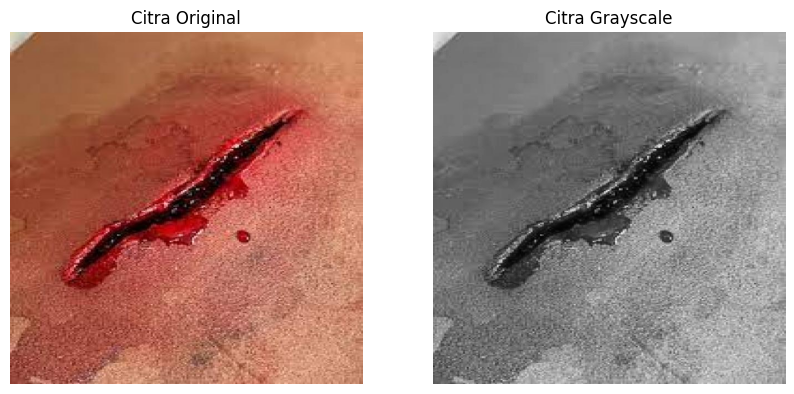

In [ ]:
citra_grayscale = cv.cvtColor(citra, cv.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(cv.cvtColor(citra, cv.COLOR_BGR2RGB))
axes[0].set_title("Citra Original")
axes[0].axis('off')
axes[1].imshow(citra_grayscale, cmap='gray')
axes[1].set_title("Citra Grayscale")
axes[1].axis('off')
plt.show()

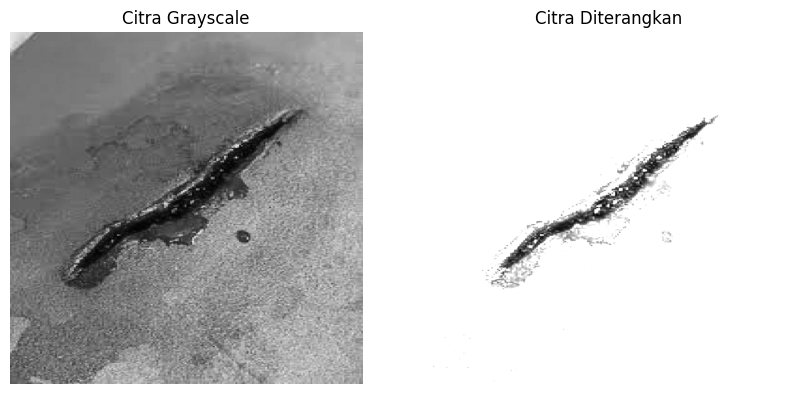

In [ ]:
brightness = 200
citra_brightened = cv.add(citra_grayscale, brightness)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(citra_grayscale, cmap='gray')
axes[0].set_title("Citra Grayscale")
axes[0].axis('off')
axes[1].imshow(citra_brightened, cmap='gray')
axes[1].set_title("Citra Diterangkan")
axes[1].axis('off')
plt.show()

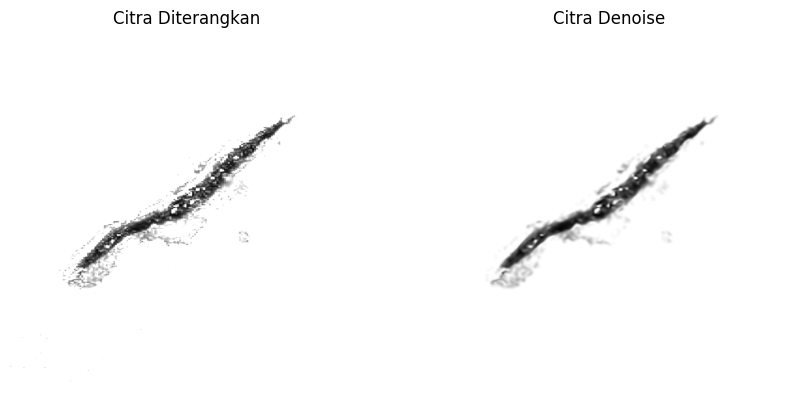

In [ ]:
citra_denoise = cv.medianBlur(citra_brightened, 3)
citra_denoise = cv.fastNlMeansDenoising(citra_denoise, None, 10, 10, 7)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(citra_brightened, cmap='gray')
axes[0].set_title("Citra Diterangkan")
axes[0].axis('off')
axes[1].imshow(citra_denoise, cmap='gray')
axes[1].set_title("Citra Denoise")
axes[1].axis('off')
plt.show()

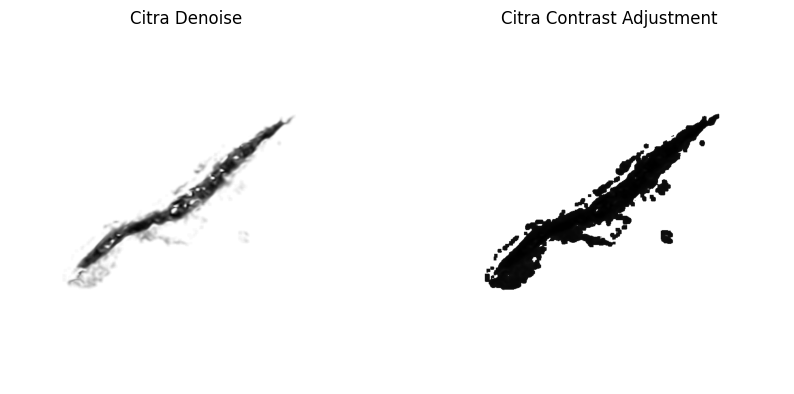

In [ ]:
citra_contrast_adjusted = cv.equalizeHist(citra_denoise)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].imshow(citra_denoise, cmap='gray')
axes[0].set_title("Citra Denoise")
axes[0].axis('off')
axes[1].imshow(citra_contrast_adjusted, cmap='gray')
axes[1].set_title("Citra Contrast Adjustment")
axes[1].axis('off')
plt.show()

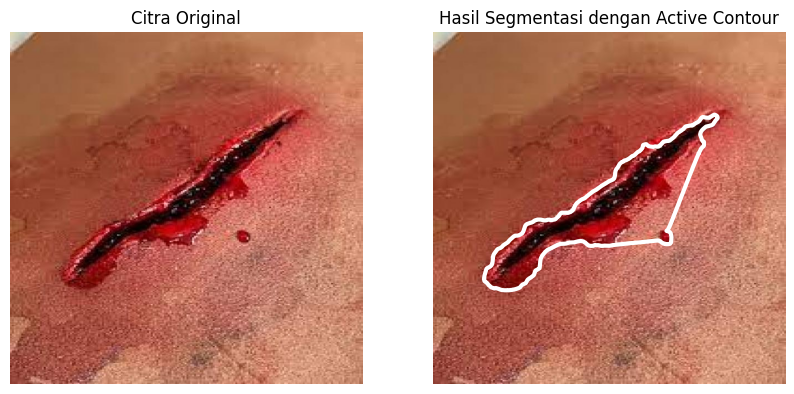

MSE : 107.27428466796874
PSNR: 13.912923668194342


In [ ]:
s = np.linspace(0, 2*np.pi, 500)
r = 300 + 300*np.sin(s)
c = 320 + 300*np.cos(s)
init = np.array([r, c]).T

# Segmentasi dengan Active Contour
snake = active_contour(gaussian(citra_contrast_adjusted, 3, preserve_range=False),
                       init, alpha=0.01, beta=0, gamma=0.001)

fig, axes = plt.subplots(1, 2,figsize=(10, 5))
axes[0].set_title("Citra Original")
axes[0].imshow(citra[...,::-1], cmap='gray')
axes[0].axis('off')
axes[1].imshow(citra[...,::-1], cmap='gray')
axes[1].plot(snake[:, 1], snake[:, 0], '-w', lw=3)
axes[1].set_title("Hasil Segmentasi dengan Active Contour")
axes[1].axis('off')
plt.show()

selisih = np.array(citra_denoise) - np.array(citra[:, :, 0])
mse = np.mean(np.square(selisih))
psnr = 10 * np.log10(255 / np.sqrt(mse))
print("MSE :", mse)
print("PSNR:", psnr)

In [ ]:
def seg_active_contour(folder, nomor, bright, x, a, y, b):
    citra = cv.imread(pick(folder, nomor))
    citra_grayscale = cv.cvtColor(citra, cv.COLOR_BGR2GRAY)
    brightness = bright
    citra_brightened = cv.add(citra_grayscale, brightness)
    citra_denoise = cv.medianBlur(citra_brightened, 3)
    citra_denoise = cv.fastNlMeansDenoising(citra_denoise, None, 10, 10, 7)
    citra_contrast_adjusted = cv.equalizeHist(citra_denoise)
    s = np.linspace(0, 2*np.pi, 500)
    r = x + a*np.sin(s)
    c = y + b*np.cos(s)
    init = np.array([r, c]).T
    snake = active_contour(gaussian(citra_contrast_adjusted, 3, preserve_range=False),
                           init, alpha=0.01, beta=0, gamma=0.001)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].set_title("Citra Original")
    axes[0].imshow(citra[..., ::-1], cmap='gray')
    axes[0].axis('off')
    axes[1].imshow(citra[..., ::-1], cmap='gray')
    axes[1].plot(snake[:, 1], snake[:, 0], '-w', lw=3)
    axes[1].set_title("Hasil Segmentasi dengan Active Contour")
    axes[1].axis('off')
    plt.show()
    selisih = np.array(citra_denoise) - np.array(citra[:, :, 0])
    mse = np.mean(np.square(selisih))
    psnr = 10 * np.log10(255 / np.sqrt(mse))
    print("MSE: ", mse)
    print("PSNR: ", psnr)

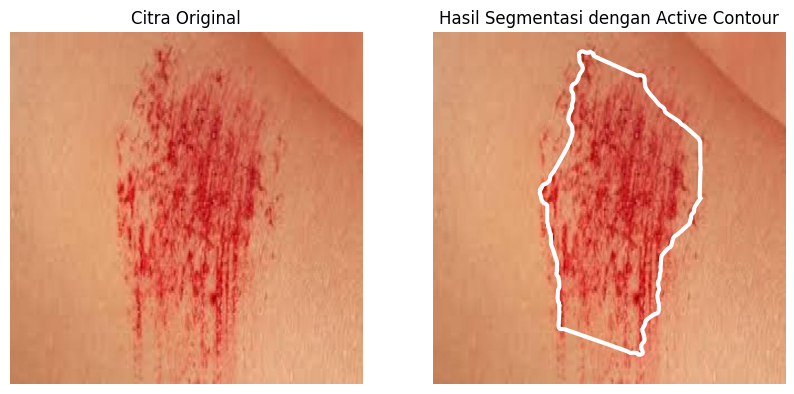

MSE:  104.5105419921875
PSNR:  13.969601304347288


In [ ]:
seg_active_contour(folder='abrasions', nomor=3, bright=144, x=300, a=300, y=320, b=300)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.80 and logs.get('val_accuracy') > 0.80):
      print("\Accuracy telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
data_dir = 'Wound_data'

In [ ]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
import imghdr
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('Wound_data')
data_iterator = data.as_numpy_iterator()

Found 325 files belonging to 4 classes.


In [ ]:
batch = data_iterator.next()

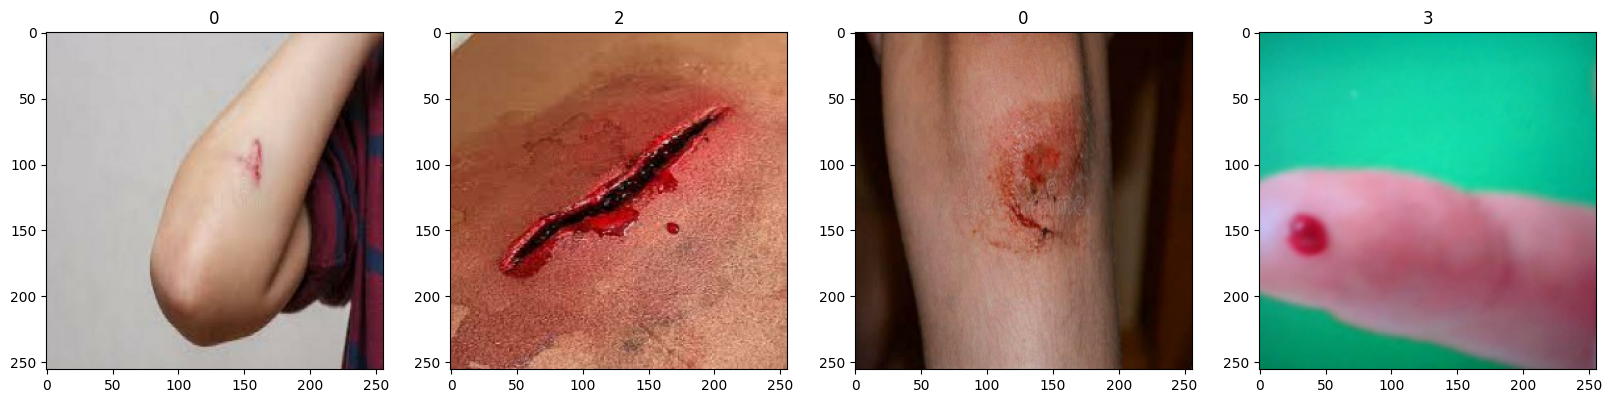

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
MAIN_DIR = "Wound_data/"

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    MAIN_DIR,
    target_size=(224, 224),
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    MAIN_DIR, # same directory as training data
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation') # set as validation data



Found 262 images belonging to 4 classes.
Found 63 images belonging to 4 classes.


In [ ]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(224, 224, 3)))

for layer in pre_trained_model.layers:
    layer.trainable = False

last_output = pre_trained_model.output

x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, x)

int_lr = 1e-9
num_epochs = 25

optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,
              batch_size=32,
              callbacks=[callbacks])

Epoch 1/25
9/9 [==============================] - 10s 806ms/step - loss: 14.6983 - accuracy: 0.3969 - val_loss: 4.1325 - val_accuracy: 0.4762
Epoch 2/25
9/9 [==============================] - 4s 477ms/step - loss: 1.5446 - accuracy: 0.6756 - val_loss: 1.7900 - val_accuracy: 0.6349
Epoch 3/25
9/9 [==============================] - 4s 496ms/step - loss: 0.7864 - accuracy: 0.7786 - val_loss: 2.1628 - val_accuracy: 0.6349
Epoch 4/25
9/9 [==============================] - 6s 633ms/step - loss: 0.7692 - accuracy: 0.7863 - val_loss: 1.9448 - val_accuracy: 0.6349
Epoch 5/25
9/9 [==============================] - 4s 478ms/step - loss: 0.8077 - accuracy: 0.7824 - val_loss: 1.8417 - val_accuracy: 0.6190
Epoch 6/25
9/9 [==============================] - 5s 534ms/step - loss: 0.6322 - accuracy: 0.8092 - val_loss: 2.9604 - val_accuracy: 0.6032
Epoch 7/25
9/9 [==============================] - 5s 529ms/step - loss: 0.6737 - accuracy: 0.8053 - val_loss: 1.7535 - val_accuracy: 0.6032
Epoch 8/25
9/9 [==

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_9[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

<function matplotlib.pyplot.show(close=None, block=None)>

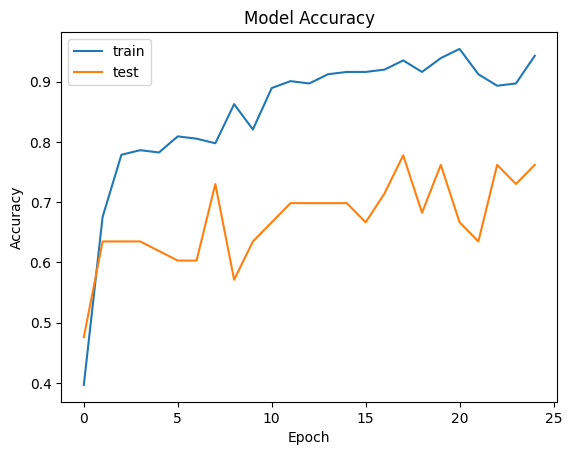

In [ ]:
#Plot Akurasi
import matplotlib.pyplot as plt
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

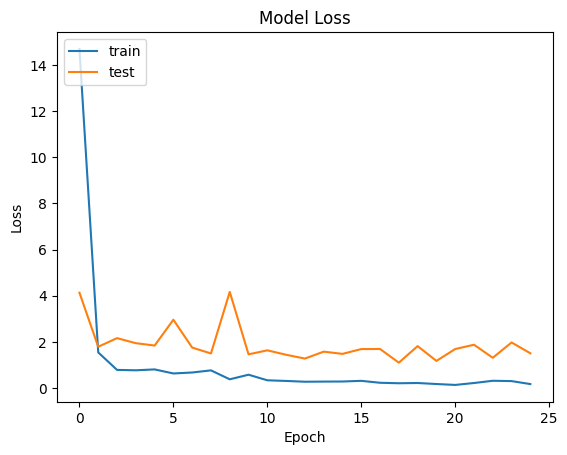

In [ ]:
#Plot Loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','test'], loc='upper left')
plt.show

<ipython-input-43-ddd9ba2fe68e>:38: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator)


Confusion Matrix
Normalized confusion matrix
Classification Report
              precision    recall  f1-score   support

   Abrasions       0.29      0.35      0.32        17
       Burns       0.24      0.25      0.24        16
         Cut       0.31      0.33      0.32        15
  Stab_wound       0.11      0.07      0.08        15

    accuracy                           0.25        63
   macro avg       0.24      0.25      0.24        63
weighted avg       0.24      0.25      0.24        63



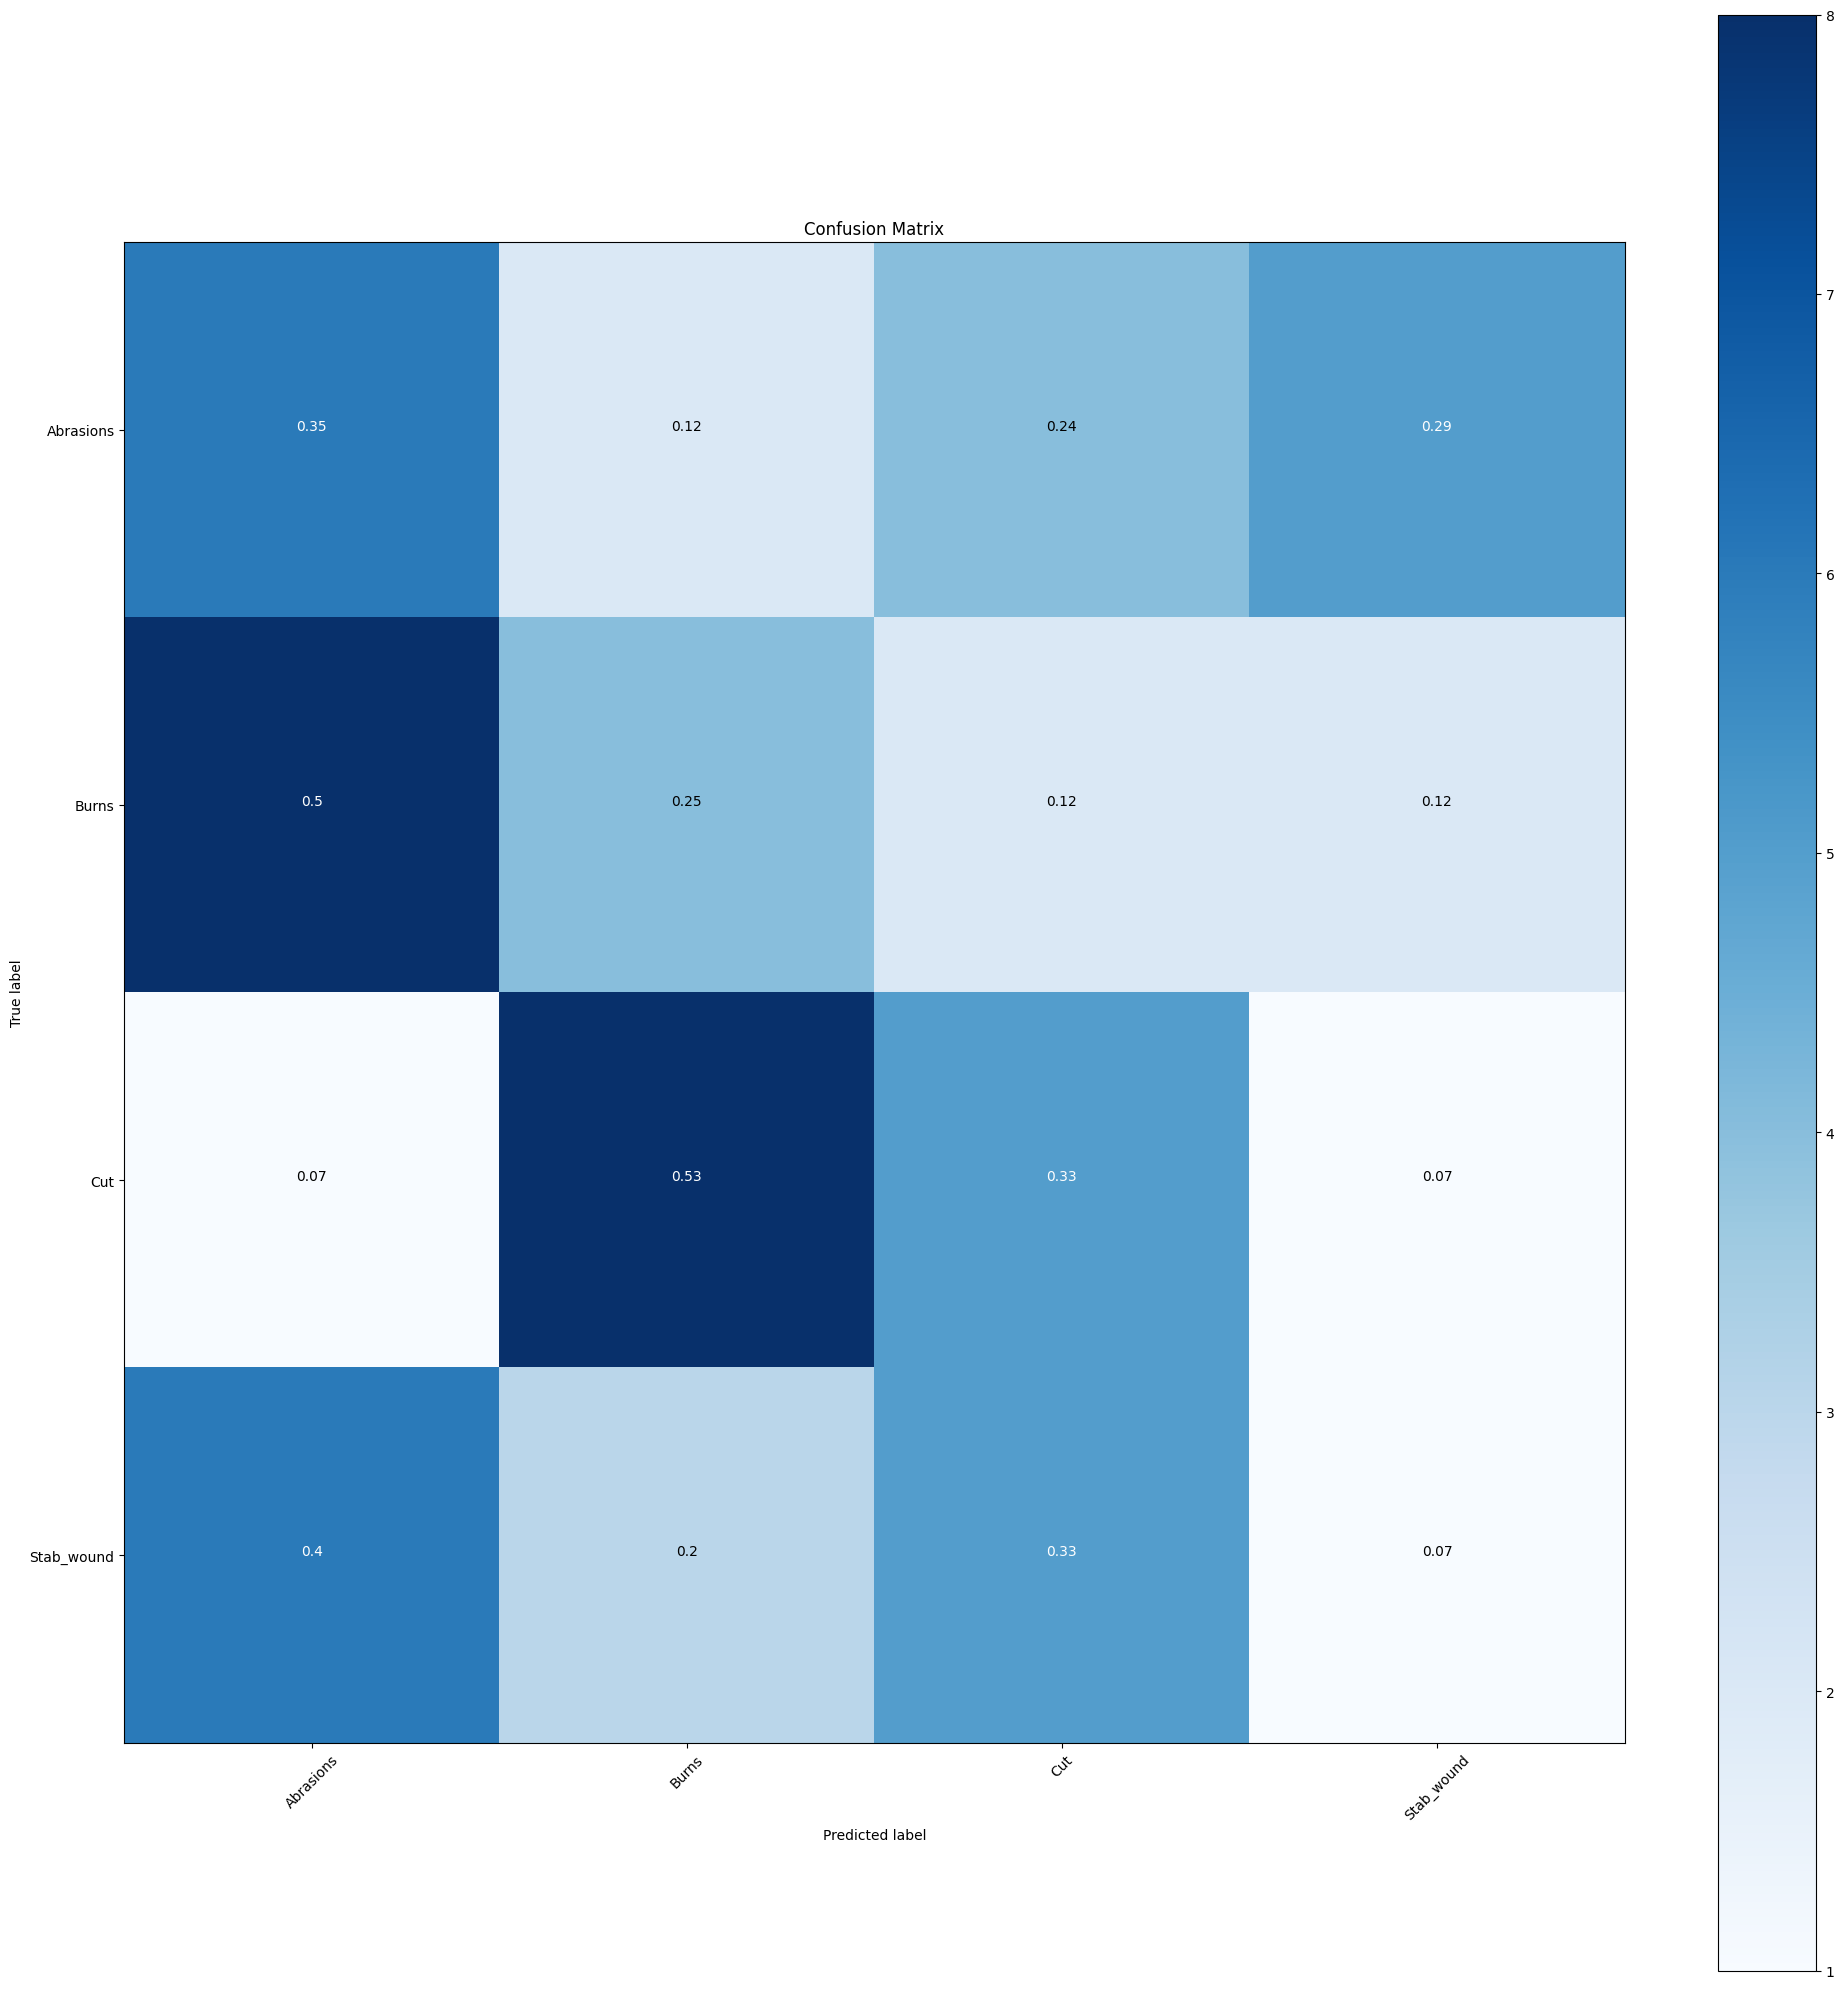

In [ ]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools
#shuffle=False
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

In [ ]:
y_true = np.random.randint(low=0, high=5, size=100, dtype=int)

print(y_true)

[4 3 0 3 0 3 3 1 1 4 2 3 0 3 2 4 2 3 0 4 1 3 1 1 3 4 0 2 4 3 4 3 3 3 0 1 1
 2 3 1 0 4 0 0 2 0 1 3 0 4 0 2 4 3 1 2 1 2 1 4 3 4 1 1 1 4 0 1 2 2 4 1 1 3
 1 3 0 0 3 3 4 2 4 2 0 3 3 1 2 3 2 3 2 3 3 0 3 0 1 1]


In [ ]:
classesIndexes, classesFrequency = np.unique(y_true, return_counts=True)


# Printing frequency (number of samples) for every class
print('classes indexes:' , classesIndexes)
print('\n')
print('classes frequency:', classesFrequency)

classes indexes: [0 1 2 3 4]


classes frequency: [18 22 16 28 16]


In [ ]:
# Importing needed libraries
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Choosing randomly 25% of classes to be changed
# Making copy of array with True classes' indexes
y_predicted = np.copy(y_true)
ii = np.random.randint(low=0, high=len(y_true), size=int(0.25 * len(y_true)), dtype=int)


# Check point
# Showing chosen indexes
print(ii)
# Iterating chosen indexes and replacing them with other classes' indexes
for i in ii:
    # Generating new class index
    y_predicted[i] = np.random.randint(low=0, high=5, dtype=int)


    # Check point
    # Showing difference between True classes' indexes and Predicted ones
    print('index = {0:2d}, True class => {1}, {2} <= Predicted class'.format(i, y_true[i], y_predicted[i]))

[58 78 36 57 31  2 43 17  2 62 10 59 95 83 56 90  4 94 68 84 78 78 33 91
 83]
index = 58, True class => 1, 2 <= Predicted class
index = 78, True class => 3, 0 <= Predicted class
index = 36, True class => 1, 2 <= Predicted class
index = 57, True class => 2, 3 <= Predicted class
index = 31, True class => 3, 4 <= Predicted class
index =  2, True class => 0, 3 <= Predicted class
index = 43, True class => 0, 2 <= Predicted class
index = 17, True class => 3, 0 <= Predicted class
index =  2, True class => 0, 3 <= Predicted class
index = 62, True class => 1, 3 <= Predicted class
index = 10, True class => 2, 1 <= Predicted class
index = 59, True class => 4, 4 <= Predicted class
index = 95, True class => 0, 2 <= Predicted class
index = 83, True class => 2, 4 <= Predicted class
index = 56, True class => 1, 0 <= Predicted class
index = 90, True class => 2, 4 <= Predicted class
index =  4, True class => 0, 2 <= Predicted class
index = 94, True class => 3, 3 <= Predicted class
index = 68, True class

In [ ]:
# Showing the main classification metrics
print(classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79        18
           1       0.86      0.82      0.84        22
           2       0.61      0.69      0.65        16
           3       0.89      0.86      0.87        28
           4       0.84      1.00      0.91        16

    accuracy                           0.82       100
   macro avg       0.81      0.82      0.81       100
weighted avg       0.83      0.82      0.82       100



In [ ]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
import tempfile
import os

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1


Saved model:
total 2828
drwxr-xr-x 2 root root    4096 Jan 10 01:30 assets
-rw-r--r-- 1 root root      57 Jan 10 01:30 fingerprint.pb
-rw-r--r-- 1 root root  366715 Jan 10 01:30 keras_metadata.pb
-rw-r--r-- 1 root root 2514406 Jan 10 01:30 saved_model.pb
drwxr-xr-x 2 root root    4096 Jan 10 01:30 variables


In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/tmp/1") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('wound_tflite.tflite', 'wb') as f:
  f.write(tflite_model)